In [1]:
import pandas as pd

# Charger 5000 lignes
business = pd.read_json("../yelp_dataset/yelp_academic_dataset_business.json", lines=True, nrows=25_000)
reviews = pd.read_json("../yelp_dataset/yelp_academic_dataset_review.json", lines=True, nrows=25_000)
users = pd.read_json("../yelp_dataset/yelp_academic_dataset_user.json", lines=True, nrows=25_000)

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import re
from textblob import TextBlob

# ===== FILTRAGE DES AVIS NÉGATIFS =====
avis_negatifs = reviews[reviews['stars'] <= 2].copy()

# ===== ANALYSE 1: MOTS FRÉQUENTS DANS LES AVIS NÉGATIFS =====
def nettoyer_texte(texte):
    if pd.isna(texte):
        return ""
    # Minuscules, garder que lettres et espaces
    texte = re.sub(r'[^a-zA-Z\s]', '', texte.lower())
    # Supprimer mots vides basiques
    mots_vides = [
        'service','because','which', 'other',
        'what','their', 'said','your', 'been',
        'food', 'there', 'place', 'just', 'would', 'like', 'back', 'good', 'about', 'from', 'very', 'here', 'even', 'them',
        'the', 'food', 'and', 'was', 'were', 'had', 'have', 'this', 'that', 'they', 'with', 'for', 'but', 'not', 'are', 'you', 'all', 'can', 'her', 'him', 'his', 'how', 'our', 'out', 'day', 'get', 'use', 'man', 'new', 'now', 'old', 'see', 'two', 'way', 'who', 'its', 'did', 'yes', 'has', 'let', 'put', 'too', 'end', 'why', 'try', 'god', 'six', 'dog', 'eat', 'ago', 'sit', 'fun', 'bad', 'mom', 'son', 'add', 'age', 'due', 'far', 'off', 'own', 'say', 'she', 'may', 'one', 'ask', 'run', 'job', 'lot', 'eye', 'box', 'car', 'oil', 'sit', 'win', 'yet', 'cut', 'let', 'six', 'hot', 'law', 'son', 'run', 'got', 'her', 'him', 'his', 'how', 'man', 'new', 'now', 'old', 'see', 'two', 'way', 'who', 'boy', 'did', 'its', 'let', 'put', 'say', 'she', 'too', 'use']
    mots = [mot for mot in texte.split() if mot not in mots_vides and len(mot) > 2]
    return ' '.join(mots)

# Nettoyer tous les avis négatifs
avis_negatifs['texte_propre'] = avis_negatifs['text'].apply(nettoyer_texte)

# Compter les mots
tous_mots = ' '.join(avis_negatifs['texte_propre']).split()
compteur_mots = Counter(tous_mots)
top_mots = compteur_mots.most_common(20)

df_mots = pd.DataFrame(top_mots, columns=['mot', 'frequence'])

# ===== ANALYSE 2: PROBLÈMES PAR CATÉGORIE =====
# Merger avec business pour avoir les catégories
# Extraire les catégories principales
def extraire_categorie_principale(categories):
    if pd.isna(categories):
        return "Non spécifié"
    cats = categories.split(',')
    # Prendre la première catégorie
    return cats[0].strip()

def analyser_mots_par_categorie(df_avis_business, top_categories=5):
    resultats = {}
    
    # Prendre les 5 catégories les plus représentées
    top_cats = df_avis_business['categorie_principale'].value_counts().head(top_categories).index
    
    for cat in top_cats:
        avis_cat = df_avis_business[df_avis_business['categorie_principale'] == cat]
        tous_mots_cat = ' '.join(avis_cat['texte_propre']).split()
        compteur_cat = Counter(tous_mots_cat)
        # Prendre les 5 mots les plus fréquents pour cette catégorie
        resultats[cat] = compteur_cat.most_common(5)
    
    return resultats

avis_avec_business = avis_negatifs.merge(business[['business_id', 'categories']], on='business_id', how='left')
avis_avec_business['categorie_principale'] = avis_avec_business['categories'].apply(extraire_categorie_principale)
problemes_par_cat = analyser_mots_par_categorie(avis_avec_business)



# ===== ANALYSE 2: PROBLÈMES PAR CATÉGORIE (VERSION CORRIGÉE) =====
# Merger avec business pour avoir les catégories
avis_avec_business = avis_negatifs.merge(business[['business_id', 'categories']], on='business_id', how='left')

# Extraire les catégories principales
def extraire_categorie_principale(categories):
    if pd.isna(categories):
        return "Non spécifié"
    cats = categories.split(',')
    # Prendre la première catégorie
    return cats[0].strip()

avis_avec_business['categorie_principale'] = avis_avec_business['categories'].apply(extraire_categorie_principale)

# OPTION 1: Garder le graphique simple (nombre d'avis négatifs par catégorie)
problemes_par_cat_simple = avis_avec_business.groupby('categorie_principale').size().sort_values(ascending=False).head(10)

# OPTION 2: Analyse plus poussée (notes moyennes par secteur)
notes_par_secteur = avis_avec_business.groupby('categorie_principale')['stars'].agg(['mean', 'count']).reset_index()
notes_par_secteur = notes_par_secteur[notes_par_secteur['count'] >= 20]  # Au moins 20 avis
notes_par_secteur = notes_par_secteur.sort_values('mean').head(10)



# ===== ANALYSE 3: ÉVOLUTION DES NOTES DANS LE TEMPS =====
# Convertir les dates
reviews['date'] = pd.to_datetime(reviews['date'])

# Calculer la note moyenne par mois
evolution_notes = reviews.groupby(reviews['date'].dt.to_period('M'))['stars'].mean().reset_index()
evolution_notes['date'] = evolution_notes['date'].dt.to_timestamp()

# Identifier les entreprises qui ont chuté
notes_par_entreprise_temps = reviews.groupby(['business_id', reviews['date'].dt.to_period('Y')])['stars'].mean().reset_index()
notes_par_entreprise_temps['date'] = notes_par_entreprise_temps['date'].dt.to_timestamp()

# Calculer la différence première année vs dernière année pour chaque entreprise
premiere_annee = notes_par_entreprise_temps.groupby('business_id').first()
derniere_annee = notes_par_entreprise_temps.groupby('business_id').last()

chute_notes = pd.merge(premiere_annee[['stars']], derniere_annee[['stars']], 
                       left_index=True, right_index=True, suffixes=('_debut', '_fin'))
chute_notes['difference'] = chute_notes['stars_fin'] - chute_notes['stars_debut']

# Entreprises qui ont le plus chuté
entreprises_en_chute = chute_notes[chute_notes['difference'] < -1].sort_values('difference').head(10)

## Page 1 : Les vrais problèmes 🔍

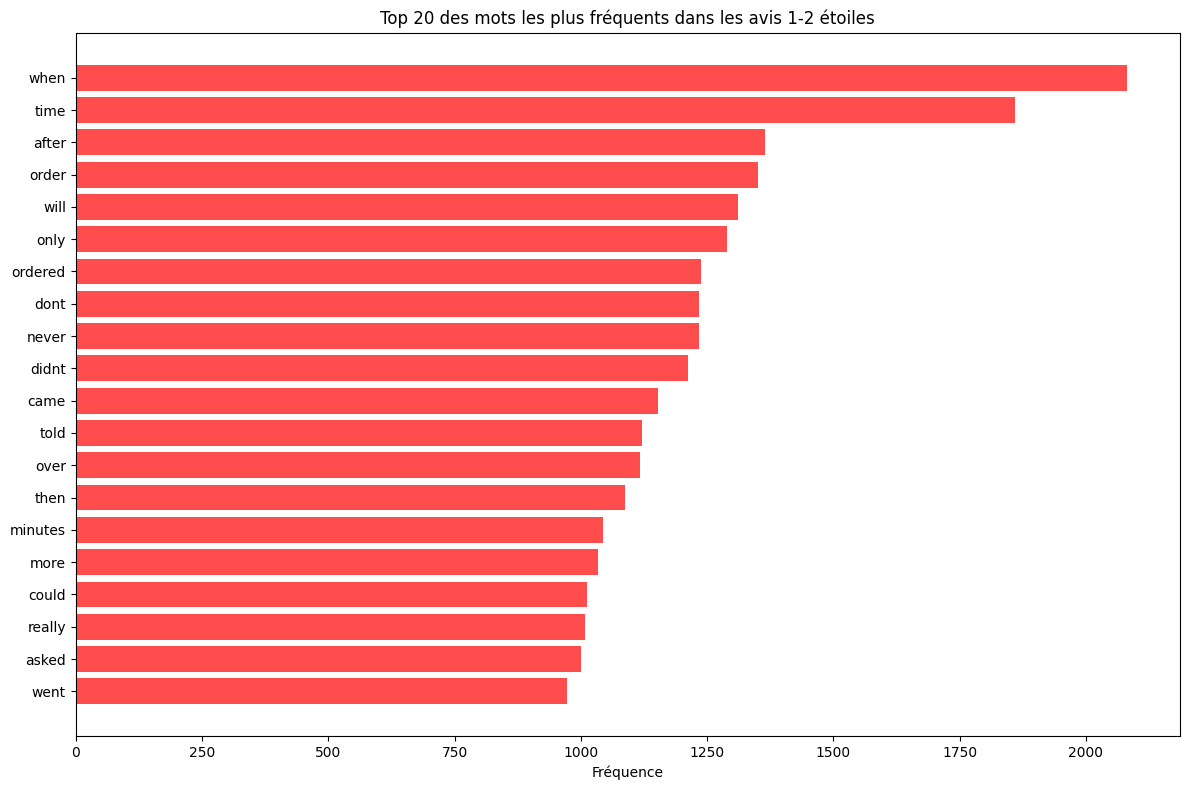

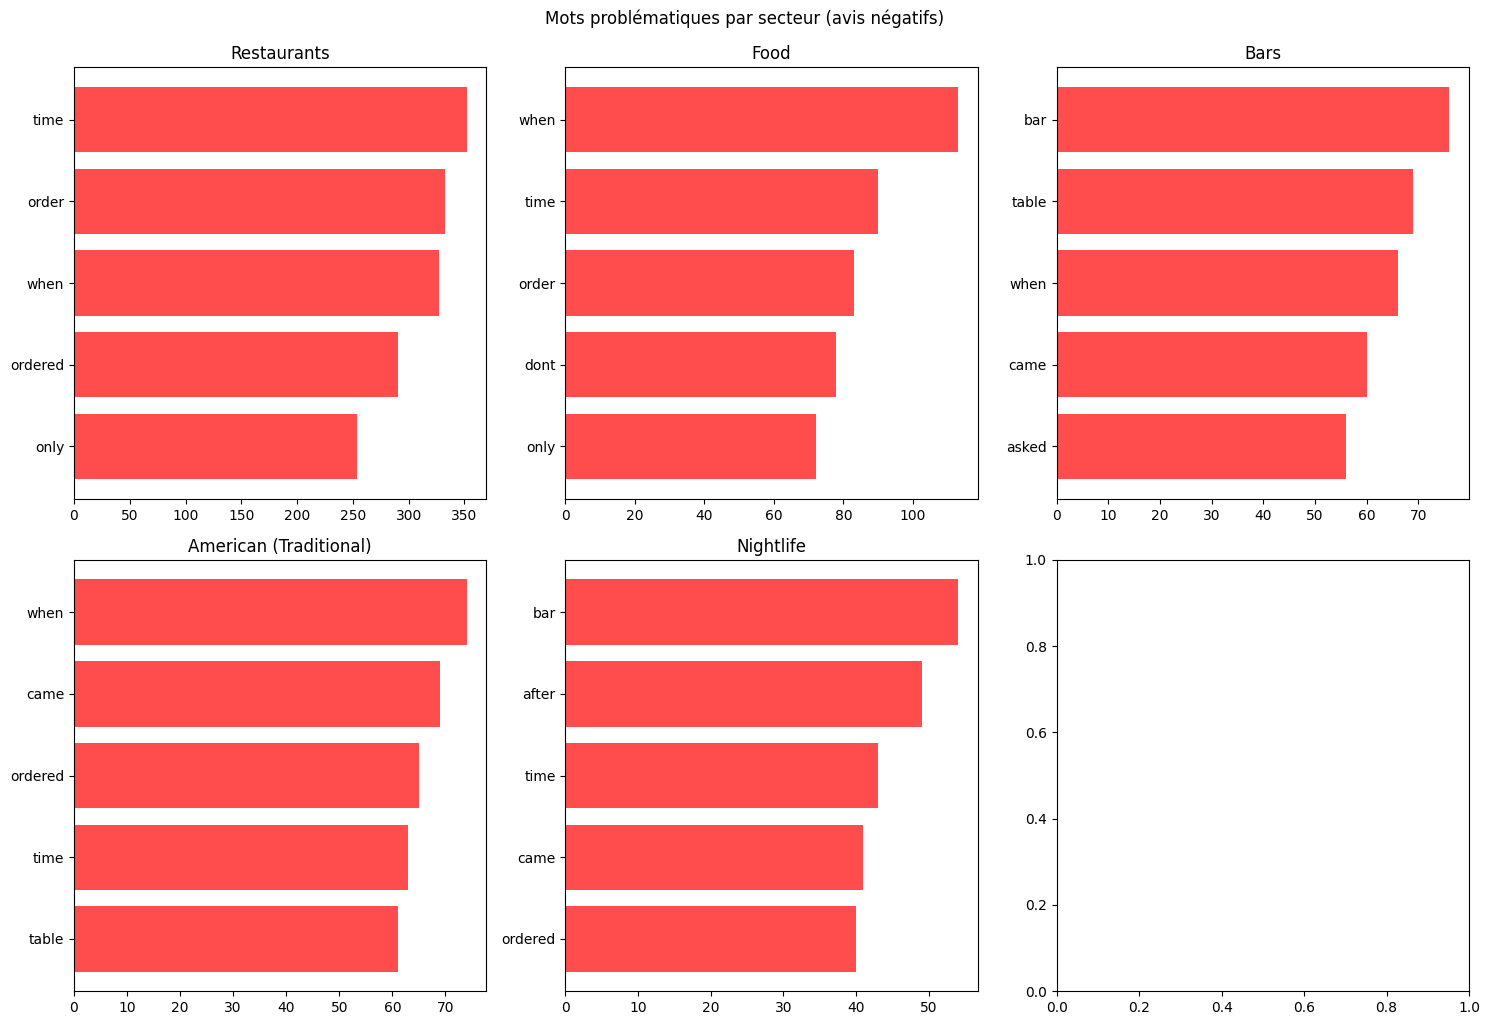

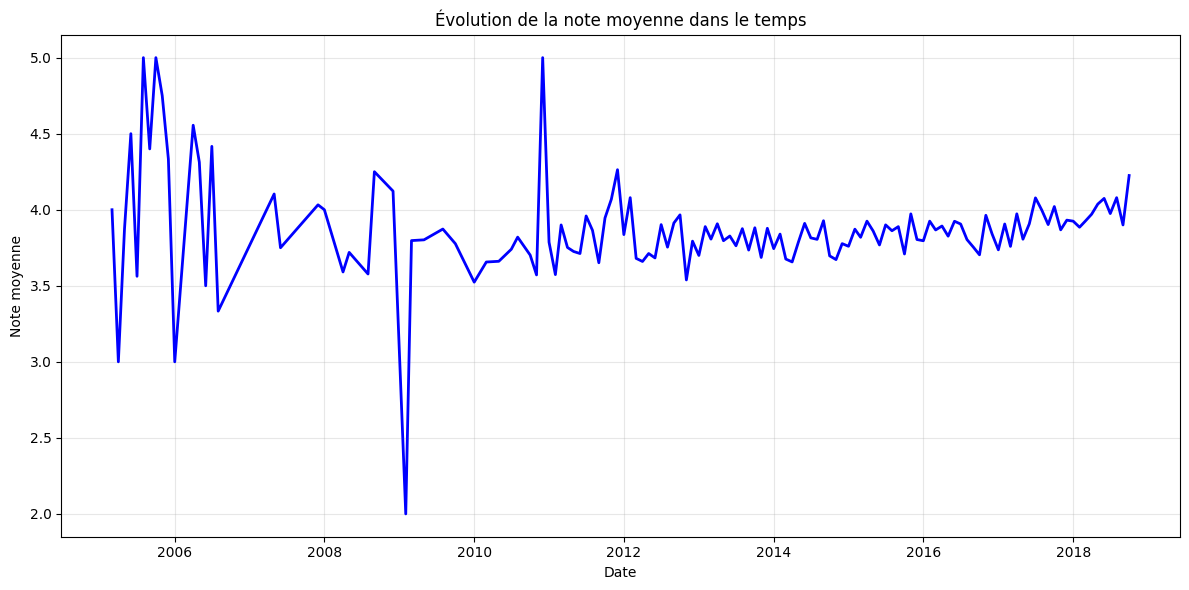

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===== GRAPHIQUE 1: TOP 20 DES MOTS DANS LES AVIS NÉGATIFS =====
plt.figure(figsize=(12, 8))
plt.barh(range(len(df_mots)), df_mots['frequence'], color='red', alpha=0.7)
plt.yticks(range(len(df_mots)), df_mots['mot'])
plt.xlabel('Fréquence')
plt.title('Top 20 des mots les plus fréquents dans les avis 1-2 étoiles')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ===== GRAPHIQUE CORRIGÉ: MOTS PROBLÉMATIQUES PAR SECTEUR =====
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (categorie, mots) in enumerate(problemes_par_cat.items()):
    if i < 6:  # Max 6 catégories
        mots_df = pd.DataFrame(mots, columns=['mot', 'frequence'])
        axes[i].barh(range(len(mots_df)), mots_df['frequence'], color='red', alpha=0.7)
        axes[i].set_yticks(range(len(mots_df)))
        axes[i].set_yticklabels(mots_df['mot'])
        axes[i].set_title(f'{categorie}')
        axes[i].invert_yaxis()

plt.tight_layout()
plt.suptitle('Mots problématiques par secteur (avis négatifs)', y=1.02)
plt.show()

# ===== GRAPHIQUE 3: ÉVOLUTION DES NOTES DANS LE TEMPS =====
plt.figure(figsize=(12, 6))
plt.plot(evolution_notes['date'], evolution_notes['stars'], linewidth=2, color='blue')
plt.title('Évolution de la note moyenne dans le temps')
plt.xlabel('Date')
plt.ylabel('Note moyenne')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
